the objective of this notebook is to
* download the dataset into tf data input pipeline 
* data cleaning
 **=> make our dataset ready for training**

# Import all the Dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Set all the Constants

In [87]:
ImageSize=255
BatchSize=32
Channels=3
Epochs=50

# Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [88]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "potatoleaf",
    shuffle=True,
    image_size=(ImageSize,ImageSize),
    batch_size=BatchSize,
    
)

Found 2149 files belonging to 3 classes.


In [89]:
class_names=dataset.class_names

In [90]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [91]:
len(dataset)

68

In [92]:
68*32
2176-2149

27

that make sense: in fact the dataset have 68 batches , each batch has 32 images. the last batch has only  27 images

In [93]:

for image_batch,label_batch in dataset.take(1):
    print("***size of the first batch in the dataset ",image_batch.numpy().shape)
    print("***batch label:",label_batch.numpy())

***size of the first batch in the dataset  (32, 255, 255, 3)
***batch label: [2 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1]


3 refers to RGB channels

# Visualize some of the images from our dataset

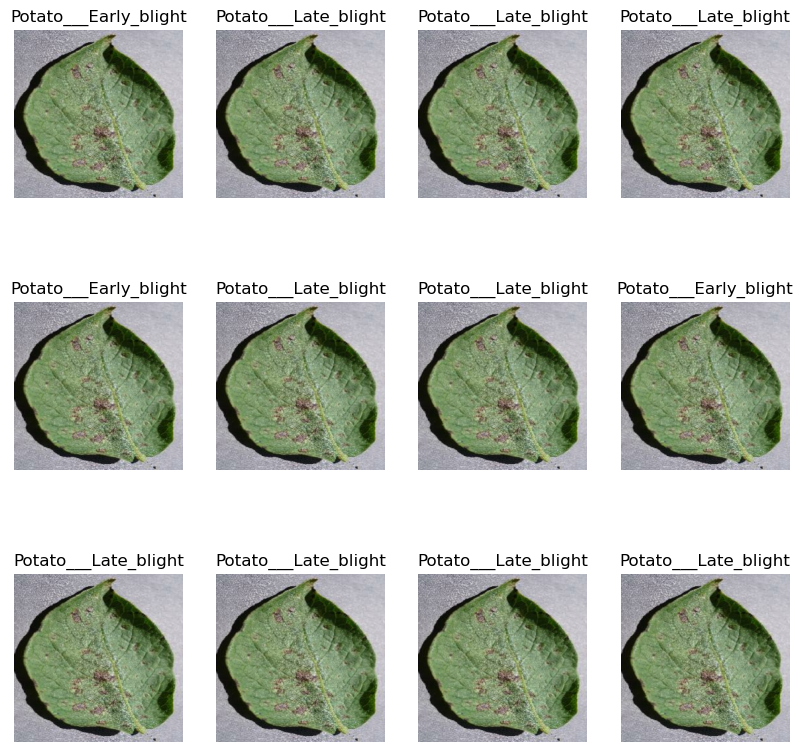

In [94]:
#we will display the 12 images in the first batch
plt.figure(figsize=(10,10))

for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch.numpy()[i]])
        plt.axis("off")# no showing the axis numbers

# Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

1) Training: Dataset to be used while training

2) Validation: Dataset to be tested against while training

3) Test: Dataset to be tested against after we trained a model

The training test will be 80% of the data
from 20% percent left ,10% will be dedicated to the validation, and the the other 10% will be for the test for testing the accuracy

Note :after each epoch we do validation on  the 10% of the validation data 

In [95]:
train_size=0.8
train_ds=dataset.take(int(len(dataset)*train_size))

In [96]:
test_ds=dataset.skip(int(len(dataset)*train_size))
len(test_ds)

14

In [97]:
val_size=0.1
print("the validation set have ",int(len(dataset)*val_size),"batches")
val_ds=test_ds.take(int(len(dataset)*val_size))

the validation set have  6 batches


In [98]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [99]:
#define a nice looking python function for the dataset spliting
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [100]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

# Cache, Shuffle, and Prefetch the Dataset

In [101]:
train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(1000)
val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(1000)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(1000)

# Building the Model

### * Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while **training** as well as **inference**. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [103]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(ImageSize, ImageSize),
    layers.Rescaling(1.0/255),
])

### * Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

#### -creating layers for preprocessing

In [104]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("haorizontal_and_vertical"),
    layers.RandomContrast(0.2),
])

In [105]:

model= tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    #first convolutional block
    layers.Conv2D(filters=32,kernel_size=3,activation="relu",padding="same"),
    layers.MaxPooling2D((2,2)),#max of this layer is 2
   #2nd convolutional block
    layers.Conv2D(filters=64,kernel_size=3,activation="relu",padding="same"),
    layers.MaxPooling2D((2,2)),
    #3rd convolutional block
    layers.Conv2D(filters=64,kernel_size=3,activation="relu",padding="same"),
    layers.MaxPooling2D((2,2)),
    #4th con block
    layers.Conv2D(filters=64,kernel_size=3,activation="relu",padding="same"),
    layers.MaxPooling2D((2,2)),
    #5th conv block
    layers.Conv2D(filters=64,kernel_size=3,activation="relu",padding="same"),
    layers.MaxPooling2D((2,2)),
    #6th conv block
    layers.Conv2D(filters=64,kernel_size=3,activation="relu",padding="same"),
    layers.MaxPooling2D((2,2)),
    #classifier head
    layers.Flatten(),
    layers.Dense(units=64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')#the last layer have 3 neurons,and sofmax activation function will normalize the probabily of the classes
    
])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_15 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_16 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_72 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_73 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_74 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_75 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_75 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_76 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_76 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_77 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_77 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer="adam",
    loss="SparseCategoricalCrossentropy",
    metrics=['accuracy']
)


In [ ]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=Epochs,
    batch_size=BatchSize,
    verbose=0

)